In [12]:
#imports
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import math
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
from torchprofile import profile_macs
import time

In [13]:
#Utility functions

@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [14]:
#LeNet5 definition
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out


In [15]:
#Fine Grain Pruner Definition
def fineGrainedPruned(tensor, sparsity):
    if sparsity>1.0:
        sparsity = 1.0
    elif sparsity<0.0:
        sparsity = 0.0

    
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)
    
    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance = torch.square(tensor)
    threshold = importance.view(-1).kthvalue(num_zeros).values
    mask = torch.gt(importance, threshold)

    tensor.mul_(mask)

    return mask.long()

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fineGrainedPruned(param, sparsity_dict[name])
        return masks

In [16]:
#Sensitivity scan
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer+1}/{len(named_conv_weights)} weight - {name}'):
            fineGrainedPruned(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, "cpu")
            if verbose:
                print(f'sparsity={sparsity:.4f}: accuracy={acc:.4f}% ', end='\n')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        accuracies.append(accuracy)
    return sparsities, accuracies

@torch.inference_mode()
def evaluate(tmodel, test_loader,device = "cpu"):
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = tmodel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [17]:
def measure(model, loader):
    dummy_input,_ = next(iter(loader))
    model = model.to('cpu')

    size = get_model_size(model=model, count_nonzero_only=True)/(8*2**10)

    latency = measure_latency(model, dummy_input)

    macs = get_model_macs(model, dummy_input)

    param = get_num_parameters(model)

    accuracy = evaluate(model,loader)
    
    return size.item(), latency, param, macs, accuracy

In [18]:
#Variables and model
batch_size=64
def dataset():
    train_data = datasets.MNIST('./data/mnist', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
    test_data = datasets.MNIST('./data/mnist', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1325,), (0.3105,))
                               ]))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader
train_loader, test_loader = dataset()

layers=["layer1.0", "layer1.1","layer2.0", "layer2.1","fc","fc1","fc2"]

model = torch.load("lenet5.pt")
model.eval()

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
#Sensitivity test
sparsities, accuracies = sensitivity_scan(
    model, test_loader, scan_step=0.04, scan_start=0.4, scan_end=1.0)

scanning 1/5 weight - layer1.0.weight:   0%|          | 0/15 [00:00<?, ?it/s]

sparsity=0.4000: accuracy=97.8400% 
sparsity=0.4400: accuracy=97.7500% 
sparsity=0.4800: accuracy=97.6700% 
sparsity=0.5200: accuracy=97.4500% 
sparsity=0.5600: accuracy=97.5900% 
sparsity=0.6000: accuracy=95.7100% 
sparsity=0.6400: accuracy=93.3700% 
sparsity=0.6800: accuracy=93.2500% 
sparsity=0.7200: accuracy=66.1000% 
sparsity=0.7600: accuracy=53.0300% 
sparsity=0.8000: accuracy=41.8800% 
sparsity=0.8400: accuracy=77.3000% 
sparsity=0.8800: accuracy=68.9100% 
sparsity=0.9200: accuracy=40.3000% 
sparsity=0.9600: accuracy=15.4500% 


scanning 2/5 weight - layer2.0.weight:   0%|          | 0/15 [00:00<?, ?it/s]

sparsity=0.4000: accuracy=98.8700% 
sparsity=0.4400: accuracy=98.8600% 
sparsity=0.4800: accuracy=98.8600% 
sparsity=0.5200: accuracy=98.7900% 
sparsity=0.5600: accuracy=98.5900% 
sparsity=0.6000: accuracy=98.6400% 
sparsity=0.6400: accuracy=98.7800% 
sparsity=0.6800: accuracy=98.7800% 
sparsity=0.7200: accuracy=98.4100% 
sparsity=0.7600: accuracy=98.1800% 
sparsity=0.8000: accuracy=97.6100% 
sparsity=0.8400: accuracy=97.2000% 
sparsity=0.8800: accuracy=96.6600% 
sparsity=0.9200: accuracy=91.1000% 
sparsity=0.9600: accuracy=69.8800% 


scanning 3/5 weight - fc.weight:   0%|          | 0/15 [00:00<?, ?it/s]

sparsity=0.4000: accuracy=98.8900% 
sparsity=0.4400: accuracy=98.8300% 
sparsity=0.4800: accuracy=98.7600% 
sparsity=0.5200: accuracy=98.7700% 
sparsity=0.5600: accuracy=98.7500% 
sparsity=0.6000: accuracy=98.7900% 
sparsity=0.6400: accuracy=98.7500% 
sparsity=0.6800: accuracy=98.8300% 
sparsity=0.7200: accuracy=98.7800% 
sparsity=0.7600: accuracy=98.7700% 
sparsity=0.8000: accuracy=98.8400% 
sparsity=0.8400: accuracy=98.5700% 
sparsity=0.8800: accuracy=97.7300% 
sparsity=0.9200: accuracy=94.6800% 
sparsity=0.9600: accuracy=91.9300% 


scanning 4/5 weight - fc1.weight:   0%|          | 0/15 [00:00<?, ?it/s]

sparsity=0.4000: accuracy=98.9000% 
sparsity=0.4400: accuracy=98.8800% 
sparsity=0.4800: accuracy=98.8500% 
sparsity=0.5200: accuracy=98.8900% 
sparsity=0.5600: accuracy=98.8700% 
sparsity=0.6000: accuracy=98.9100% 
sparsity=0.6400: accuracy=98.9100% 
sparsity=0.6800: accuracy=98.9300% 
sparsity=0.7200: accuracy=98.8600% 
sparsity=0.7600: accuracy=98.8600% 
sparsity=0.8000: accuracy=98.8500% 
sparsity=0.8400: accuracy=98.7600% 
sparsity=0.8800: accuracy=98.5300% 
sparsity=0.9200: accuracy=97.1900% 
sparsity=0.9600: accuracy=94.2900% 


scanning 5/5 weight - fc2.weight:   0%|          | 0/15 [00:00<?, ?it/s]

sparsity=0.4000: accuracy=98.7500% 
sparsity=0.4400: accuracy=98.7200% 
sparsity=0.4800: accuracy=98.7500% 
sparsity=0.5200: accuracy=98.7000% 
sparsity=0.5600: accuracy=98.6900% 
sparsity=0.6000: accuracy=98.6500% 
sparsity=0.6400: accuracy=98.7100% 
sparsity=0.6800: accuracy=98.5800% 
sparsity=0.7200: accuracy=98.3900% 
sparsity=0.7600: accuracy=98.4900% 
sparsity=0.8000: accuracy=97.8600% 
sparsity=0.8400: accuracy=96.3300% 
sparsity=0.8800: accuracy=87.3000% 
sparsity=0.9200: accuracy=63.4900% 
sparsity=0.9600: accuracy=40.2200% 


In [20]:
#Original Accuracy
orig_accuracy = evaluate(model, test_loader)
print("Original accuracy: ",orig_accuracy,"%")

Original accuracy:  98.88 %


accuracies:  [97.84, 97.75, 97.67, 97.45, 97.59, 95.71, 93.37, 93.25, 66.1, 53.03, 41.88, 77.3, 68.91, 40.3, 15.45] layer1.0.weight
accuracies:  [98.87, 98.86, 98.86, 98.79, 98.59, 98.64, 98.78, 98.78, 98.41, 98.18, 97.61, 97.2, 96.66, 91.1, 69.88] layer2.0.weight
accuracies:  [98.89, 98.83, 98.76, 98.77, 98.75, 98.79, 98.75, 98.83, 98.78, 98.77, 98.84, 98.57, 97.73, 94.68, 91.93] fc.weight
accuracies:  [98.9, 98.88, 98.85, 98.89, 98.87, 98.91, 98.91, 98.93, 98.86, 98.86, 98.85, 98.76, 98.53, 97.19, 94.29] fc1.weight
accuracies:  [98.75, 98.72, 98.75, 98.7, 98.69, 98.65, 98.71, 98.58, 98.39, 98.49, 97.86, 96.33, 87.3, 63.49, 40.22] fc2.weight


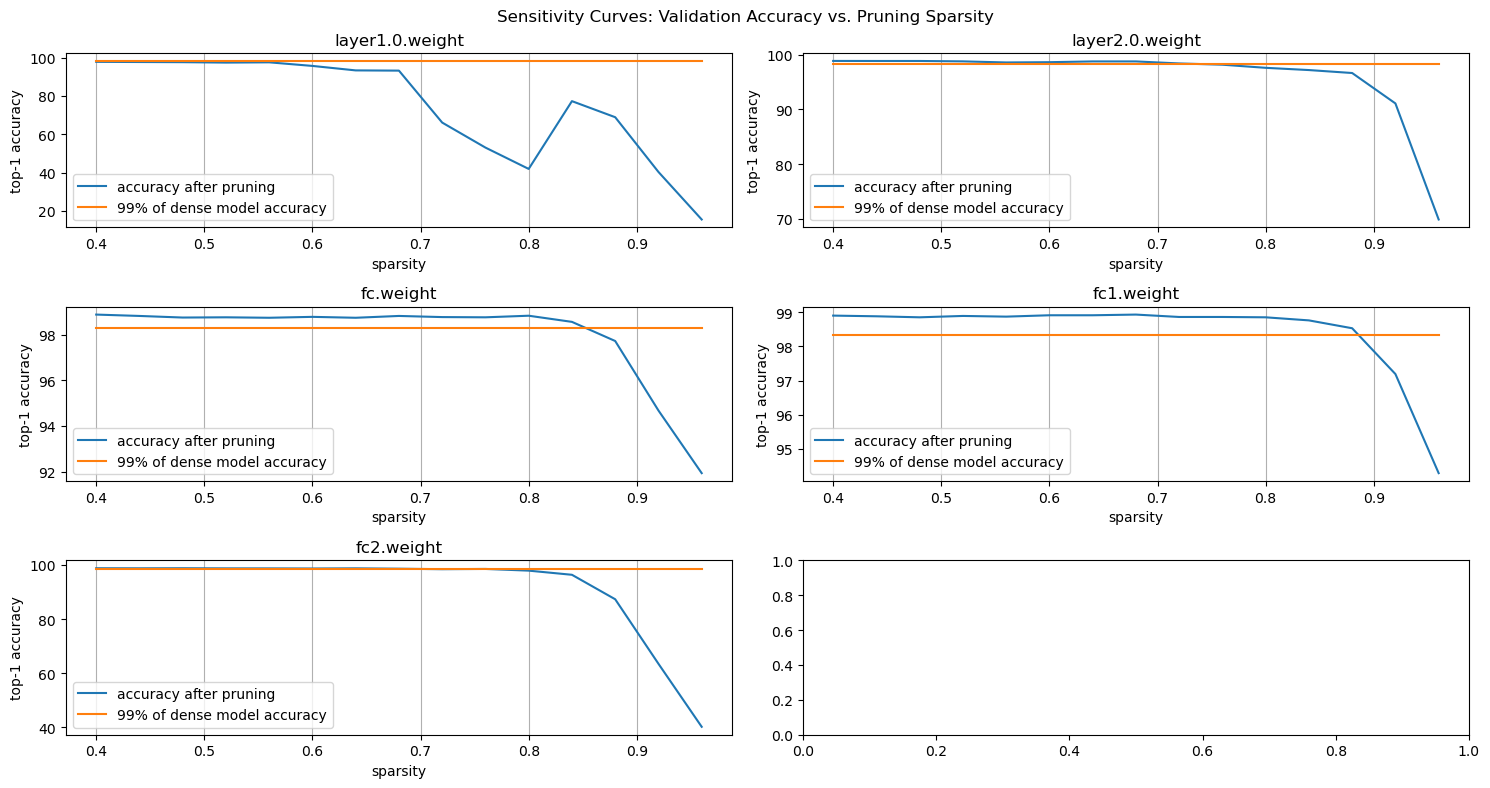

In [21]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            print("accuracies: ",accuracies[plot_index], name)
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, orig_accuracy)

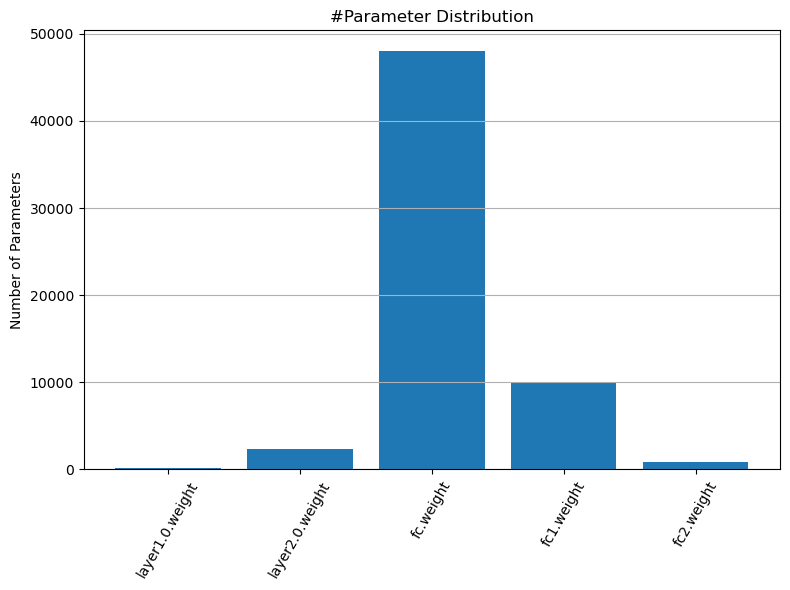

In [22]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [23]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False, title="Bruh"):
    fig, axes = plt.subplots(2,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

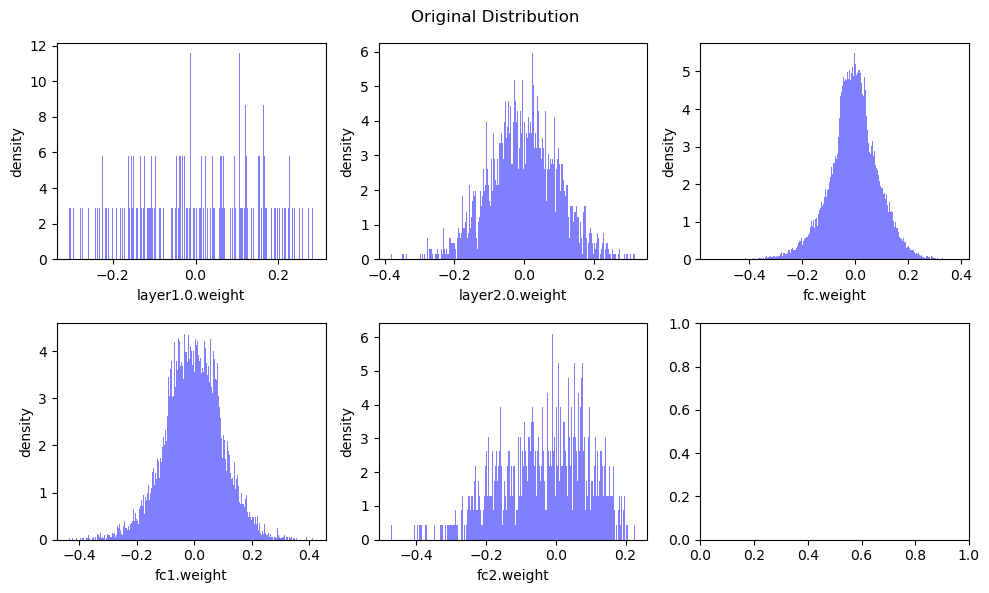

The sparsity of each layer will become
  layer1.0.weight: 0.50
  layer2.0.weight: 0.50
  fc.weight: 0.50
  fc1.weight: 0.50
  fc2.weight: 0.50
Sparse model has size=0.12 MiB = 50.23% of dense model size
Sparse model has accuracy=96.78% before finetuning


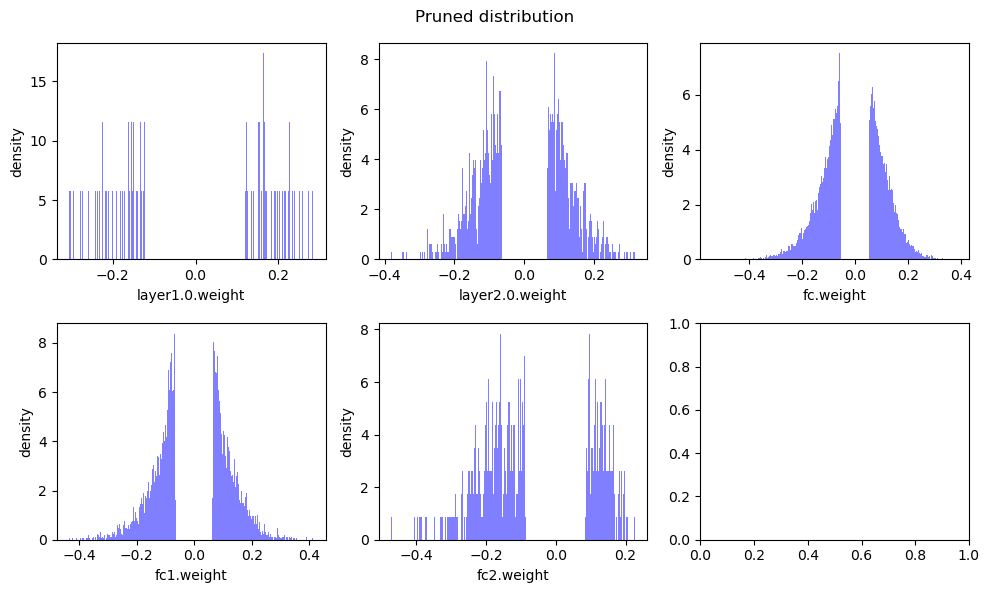

In [24]:
#Compare original and pruned
plot_weight_distribution(model,title="Original Distribution")


sparsity_dict={
    "layer1.0.weight":0.50,
    "layer2.0.weight":0.50, 
    "fc.weight":0.50,
    "fc1.weight":0.50,
    "fc2.weight":0.50
}
dense_model_size = get_model_size(model)
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'The sparsity of each layer will become')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, test_loader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before finetuning")

plot_weight_distribution(model, count_nonzero_only=True,title="Pruned distribution")

In [25]:
#fiddling with sparsity
model = torch.load("lenet5.pt")
dense_model_size = get_model_size(model)
pruner = FineGrainedPruner(model, sparsity_dict)

results=[] #Tuples of things
layer1_ratio = [0.5,0.6,0.8,0.9]
layer2_ratio = [0.5,0.9,0.94]
fc_ratio = [0.5,0.8,0.93,0.99]
fc1_ratio = [0.5,0.6,0.7,0.8,0.99]
fc2_ratio = [0.5,0.7,0.81,0.87,0.90]

count = 0
max = len(layer1_ratio)*len(layer2_ratio)*len(fc_ratio)*len(fc1_ratio)*len(fc2_ratio)
for l1 in layer1_ratio:
    for l2 in layer2_ratio:
        for fc in fc1_ratio:
            for fc1 in fc1_ratio:
                for fc2 in fc2_ratio:
                    count+=1
    
                    model = torch.load("lenet5.pt")
                    sparsity_dict={
                        "layer1.0.weight":l1,
                        "layer2.0.weight":l2, 
                        "fc.weight":fc,
                        "fc1.weight":fc1,
                        "fc2.weight":fc2
                    }
                    pruner.prune(model, sparsity_dict)
                    sparse_model_size = get_model_size(model, count_nonzero_only=True)
                    sparse_model_accuracy = evaluate(model, test_loader)
                    results.append(((sparse_model_size / dense_model_size).item(), sparse_model_accuracy))
                    print("Iteration: ",count)
                    


Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Iteration:  67
Iter

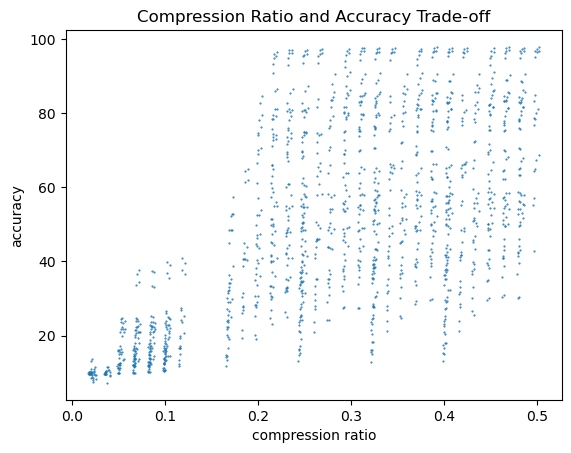

In [29]:
sorted(results)
compression_ratio = []
accuracy = []
for i in range(len(results)):
    compression_ratio.append(results[i][0])
    accuracy.append(results[i][1])

plt.scatter(compression_ratio, accuracy,marker=".",s=1)
plt.ylabel("accuracy")
plt.xlabel("compression ratio")
plt.title("Compression Ratio and Accuracy Trade-off")
plt.show()

In [30]:
#Measure fine grained model
model = torch.load("lenet5.pt")
sparsity_dict={
    "layer1.0.weight":0.50,
    "layer2.0.weight":0.50, 
    "fc.weight":0.50,
    "fc1.weight":0.50,
    "fc2.weight":0.50
}
pruner = FineGrainedPruner(model,sparsity_dict)
prune_size, prune_latency, prune_param, prune_macs, prune_accuracy = measure(model,test_loader)
torch.save(model,"prunedLenet5.pt")
print("size: ", prune_size, "KB")
print("original_latency: ",prune_latency)
print("macs: ",prune_macs)
print("param: ",prune_param)
print("accuracy: ",prune_accuracy,"%")
print("masks:",pruner.masks)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::reshape". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


size:  121.15234375 KB
original_latency:  0.0024178290367126466
macs:  27060736
param:  61750
accuracy:  96.78 %
masks: {'layer1.0.weight': tensor([[[[0, 0, 0, 1, 0],
          [1, 1, 1, 1, 0],
          [0, 1, 1, 1, 0],
          [1, 0, 1, 1, 0],
          [1, 1, 0, 1, 0]]],


        [[[1, 1, 1, 0, 0],
          [1, 0, 0, 0, 0],
          [0, 1, 1, 0, 1],
          [0, 0, 0, 1, 0],
          [0, 0, 1, 1, 0]]],


        [[[0, 1, 0, 1, 1],
          [1, 1, 0, 0, 1],
          [0, 0, 1, 1, 1],
          [1, 0, 0, 1, 0],
          [0, 0, 1, 1, 0]]],


        [[[0, 0, 1, 0, 0],
          [1, 0, 1, 1, 0],
          [0, 1, 0, 1, 1],
          [0, 1, 1, 1, 1],
          [0, 0, 1, 1, 0]]],


        [[[1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0],
          [1, 1, 0, 0, 0],
          [1, 1, 1, 0, 1],
          [1, 0, 1, 0, 1]]],


        [[[0, 1, 0, 1, 0],
          [1, 1, 0, 1, 0],
          [1, 1, 0, 0, 0],
          [1, 1, 0, 0, 0],
          [1, 1, 1, 0, 0]]]]), 'layer2.0.weight': tensor(